# Preamble

In [9]:
import os 
repo = '/Users/Ismael/igoogle-drive/code/lensing/SMFF/'
os.chdir(repo)

In [10]:
import analysis.fisher as fisher
import analysis.galfun as galfun
import matplotlib.pyplot as plt 
import numpy as np 
import galsim
from copy import deepcopy 

## Image renderer and Gparamters

In [11]:
nx = ny = img_size = 130 
image_renderer = galfun.ImageRenderer(pixel_scale=.2, nx=img_size,ny=img_size)

In [12]:
g_parameters1 = galfun.GParameters('project-tutoriaNew5/') 
fish1 = fisher.Fisher(g_parameters=g_parameters1,image_renderer=image_renderer, snr = 20)
print(g_parameters1.id_params,'\n \n ', fish1.biases)
print() 
print() 
g_parameters2 = galfun.GParameters('project-tutoriaNew6/') 
fish2 = fisher.Fisher(g_parameters=g_parameters2,image_renderer=image_renderer, snr = 20)
print(g_parameters2.id_params,'\n \n ', fish2.biases)

{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'psf_gaussian'), ('y0', 0.0), ('g2', 0.0), ('flux', 1.0), ('hlr', 1.0), ('g1', 0.2), ('x0', 0.0), ('psf_fwhm', 0.7), ('psf_flux', 1.0)])} 
 
  {'flux_1': 0.005023092, 'x0_1': 6.1546074e-11, 'y0_1': 4.6566129e-10, 'hlr_1': -0.0023890506, 'g1_1': 0.00031969883, 'g2_1': 5.6963239e-09}


{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'psf_gaussian'), ('x0', 0.0), ('y0', 0.0), ('flux', 1.0), ('e2', 0.1), ('hlr', 1.0), ('e1', 0.1), ('psf_fwhm', 0.7), ('psf_flux', 1.0)])} 
 
  {'flux_1': 0.005021242, 'x0_1': -4.3692491e-11, 'y0_1': 9.4098523e-14, 'hlr_1': -0.0023023873, 'e1_1': -0.0010933706, 'e2_1': -0.0010933728}


## useful functions 

In [13]:
colors =['b','g','r','c','m','y']

In [14]:
def get_new_fish(orig_g_parameters, param_names, new_values, image_renderer): 
    id_params_new = deepcopy(orig_g_parameters.id_params)
    for param, value in zip(param_names, new_values) : 
        id_params_new['1'][param] = value 
    new_g_parameters = galfun.GParameters(id_params= id_params_new)
    new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
    return new_fish

In [15]:
def get_R2(fish, psf_T, img_size): 
    return 1 - psf_T / (2 * fish.model.calculateMomentRadius(size = img_size, scale = .2 ,rtype= 'trace')**2 ) 

In [16]:
def prepare_hlrss1(starts, end, pts): 
    hlrss = []
    for start in starts: 
        hlrs = np.linspace(start, end, pts)
        hlrss.append(hlrs)
    return hlrss 

def prepare_hlrss_nlinear(starts, end, pts): 
    hlrss = []
    for start in starts: 
        ys = np.linspace(start**(-2), end**(-2), pts)
        hlrs = ys**(-0.5)
        hlrss.append(hlrs)
    return hlrss 


def get_params_to_vary(vary , g,  hlr): 
    if vary == 'both': 
        return [g, g, hlr]
    
    elif vary == 'g1': 
        return [g,0,hlr]
    
    elif vary == 'g2' :
        return [0, g, hlr]
    else: 
        raise ValueError

In [17]:
def plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, 
                      img_size, bias_param_names, vary = 'both', formatting = None,
                      plot_eps = False, plot_chi = False, sqrt = False, lg_precision =1 ): 
    
    fig, ax= plt.subplots(figsize=(10, 10))
    
    if plot_eps: 
        for g,c, hlrs in zip(gs, colors, hlrss):
            bias = []
            R2s = []
        
            for hlr in hlrs:
                params_to_vary = get_params_to_vary(vary, g, hlr)
                legend_label = get_legend_label(vary, params_to_vary[0], params_to_vary[1], lg_precision)
                new_fish = get_new_fish(g_parameters1, ['g1', 'g2', 'hlr'], params_to_vary, image_renderer)        
                R2 = get_R2(new_fish, psf_T, img_size)
                if sqrt: 
                    bias_sign = np.sign(new_fish.biases['g1_1'])
                    bias.append(bias_sign * np.sqrt(new_fish.biases['g1_1']**2 + new_fish.biases['g2_1']**2) )
                else: 
                    bias.append(new_fish.biases[bias_param_names[0]])
                R2s.append(R2)
            plt.plot(R2s, bias, color = c, label = legend_label)
        
    if plot_chi:
        for g,c, hlrs in zip(gs, colors, hlrss):
            bias = []
            R2s = [] 

            #get corresponding e 
            shr = galsim.shear.Shear(g1 = g, g2 = g )
            e1, e2 = shr.e1, shr.e2  #should be the same.
            for hlr in hlrs:
                params_to_vary_e = get_params_to_vary(vary, e1 , hlr)
                params_to_vary_g = get_params_to_vary(vary, g , hlr)
                legend_label = get_legend_label(vary, params_to_vary_g[0], params_to_vary_g[1], lg_precision)
                #print(g, e1, e2, hlr)
                new_fish = get_new_fish(g_parameters2, ['e1', 'e2', 'hlr'], params_to_vary_e, image_renderer)    
                R2 = get_R2(new_fish, psf_T, img_size)
                if sqrt: 
                    bias_sign = np.sign(new_fish.biases['e1_1'])
                    bias.append(bias_sign * np.sqrt(new_fish.biases['e1_1']**2 + new_fish.biases['e2_1']**2) )
                else: 
                    bias.append(new_fish.biases[bias_param_names[1]])
                R2s.append(R2)
            if plot_eps: 
                label = None
            else: 
                label = legend_label
            plt.plot(R2s, bias, '--', color = c, label= label ) 
        

    if formatting: 
        formatting(ax)        
    

In [18]:
def single_eps_plot(g, hlrs, g_parameters1, img_size): 
    fig, ax= plt.subplots(figsize=(10, 10))
    bias = []
    R2s = [] 
    
    for hlr in hlrs:
        new_fish = get_new_fish(g_parameters1, ['g1', 'g2', 'hlr'], [g, g, hlr], image_renderer)        
        R2 = get_R2(new_fish, psf_T, img_size)
        bias.append(new_fish.biases['g1_1'])
        R2s.append(R2)
    plt.plot(R2s, bias, color = 'red', label = f'g = {g:.2g}' )
    
def single_chi_plot(g, hlrs, g_parameters1, img_size): 
    fig, ax= plt.subplots(figsize=(10, 10))
    bias = []
    R2s = [] 

    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same.
    for hlr in hlrs:
        #print(g, e1, e2, hlr)
        new_fish = get_new_fish(g_parameters2, ['e1', 'e2', 'hlr'], [e1, e2, hlr], image_renderer)    
        R2 = get_R2(new_fish, psf_T, img_size)
        bias.append(new_fish.biases['e1_1'])
        R2s.append(R2)
    plt.plot(R2s, bias, '--', color = 'red') 

In [19]:
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
"""
Custom Handler for LineCollection instances.
"""
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = ((height) / (numlines + 1)) * np.ones(xdata.shape, float)
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [20]:
def get_legend_label(vary, eps1, eps2, precision): 
    eps1_string = "{:.{prec}f}".format(eps1, prec = precision)
    eps2_string = "{:.{prec}f}".format(eps2, prec = precision)
    if eps1 == eps2 and vary == 'both': 
        return f"$\\varepsilon_{1} = \\varepsilon_{2} = {eps1_string}$"
    else: 
        return f"$\\varepsilon_{1} = {eps1_string}, \\varepsilon_{2} = {eps2_string} $"

In [21]:
def get_formatting(xlabel, ylabel,  gs, vary = 'both', xlim = None , ylim = None, check_sci = False, 
                   dash_and_solid = False, hline = None, vline = None, legend_size = 18, lg_precision = 1):
    
    plt.rc('text',usetex=True)
    
    def formatting(ax): 
        ax.tick_params(axis='both', which='major', labelsize=18)

        ax.set_xlabel(xlabel, size = 22)
        ax.set_ylabel(ylabel, size = 22 )
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.yaxis.set_ticks_position('both')
        
        if 'specific' in check_sci:
            pwr = float(check_sci[len('specific') + 1:]) 
            yticks = ax.get_yticks() 
            print(to_tex(yticks*pwr))
            ax.yaxis.set(ticks=yticks, ticklabels=to_tex(yticks*pwr))
            plt.rc('text',usetex=True) #turn into tex again. 
        
        elif check_sci == True: 
            ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
            ax.get_yaxis().get_offset_text().set_size(30)
        
        elif check_sci == 'yes': 
            ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
            ax.get_yaxis().get_offset_text().set_size(1)
            

        if dash_and_solid: 
            #create double solid and dashed lines: 
            line = [[(0, 0)]]
            #set up the line collections
            lines = [] 
            labels = [] 
            for g,color in zip(gs, colors):
                params_to_vary = get_params_to_vary(vary , g,  0)
                leg_label = get_legend_label(vary, params_to_vary[0], params_to_vary[1], lg_precision)
                lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
                lines.append(lc)
                labels.append(leg_label)
                
            #append one/two last line(s) that indicates that bias on eps is 'solid' and chi is 'dashed'. 
            line = [[(0, 0)]]
            line1 = LineCollection(line, linestyles = ['solid'], colors = ['black'])
            label1 = '$b(\\varepsilon)$'
            line2 = LineCollection(line, linestyles = ['dashed'], colors = ['black'])
            label2 = '$b(\\chi)$'
            lines.append(line1); lines.append(line2)
            labels.append(label1); labels.append(label2)

            plt.legend(lines, labels, loc = 'best',prop={'size': legend_size}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)
                    
        else: 
            plt.legend(loc = 'best',prop={'size': legend_size})
            
        if hline: 
            ax.axhline(hline[0], lw = hline[1], c = hline[2])
            
        if vline: 
            ax.axvline(vline[0], lw = vline[1], c = vline[2])

    
    return formatting 

def formatting2(ax): 
    plt.legend() 

In [34]:
def to_tex(arr): 
    tex_arr = [] 
    for x in arr: 
        tex_x = "${:.0f}$".format(x)
        tex_arr.append(tex_x)
    return tex_arr 

## Create nominal PSF and size. 

In [23]:
psf = galsim.Gaussian(fwhm = g_parameters1.id_params['1']['psf_fwhm'])
#obtain second moment trace with big image to avoid inacurracies 
print(f'psf sigma is: {psf.sigma}')
print(f'psf hlr is: {psf.half_light_radius}')
print(f"from moments without image : {psf.calculateMomentRadius(size = (100,100), rtype = 'trace')}")
print(f"from moments with image : {psf.drawImage(nx = 100, ny = 100, scale= 0.02).calculateMomentRadius(rtype = 'trace')}")


psf sigma is: 0.29726263010080667
psf hlr is: 0.35
from moments without image : 0.29726263010080667
from moments with image : 0.29592194770506486


In [24]:
psf_T = 2 * psf.calculateMomentRadius(rtype = 'trace')**2  # = to sigma for uncolvolved Gaussians, and exact. 
print(psf_T)

0.176730142508898


# Check size

In [17]:
# criteria: pizel extent > 2 * sigma(galaxy)

In [18]:
#test size of image. 
id_params_new = deepcopy(g_parameters1.id_params)
id_params_new['1']['hlr'] = 3.5
new_g_parameters = galfun.GParameters(id_params= id_params_new)
new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)

test = new_fish.model.calculateMomentRadius(size = 200, rtype = 'trace') * 2 /0.2 
print(f'is {img_size/2} bigger than {test:.2f}?')

print(f'This R2 is {get_R2(new_fish, psf_T, img_size)}')

is 65.0 bigger than 31.62?
This R2 is 0.9908213982024471


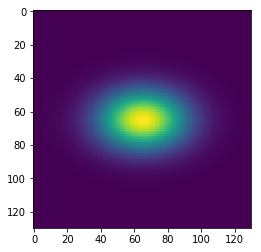

In [19]:
#by eye
plt.imshow(new_fish.image.array)

In [280]:
# does the postage stamp look big enough ? 

# Understand R2

In [281]:
image_renderer = galfun.ImageRenderer(pixel_scale=.2, nx=200,ny=200)

In [282]:
hlrs = np.linspace(0.3, 0.6, 20)
gs = np.linspace(0, 0.5, 6)

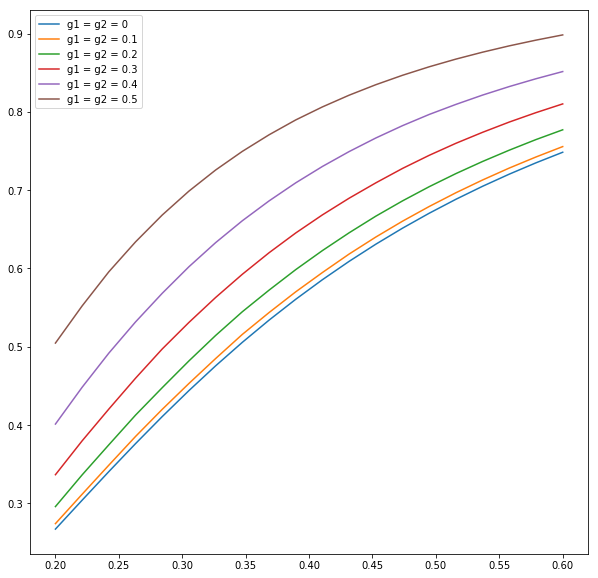

In [61]:
plt.figure(figsize= (10,10))
for g in gs: 
    R2s = [] 
    for hlr in hlrs: 
        new_fish= get_new_fish(g_parameters1, ['g1', 'g2', 'hlr'], [g, g, hlr], image_renderer)
        R2 = get_R2(new_fish, psf_T, img_size)
        R2s.append(R2)
    plt.plot(hlrs, R2s, label = f'g1 = g2 = {g:.2g}')
plt.legend()

In [ ]:
starts = [.275,.27,.255, .230,.2]             #manually find the starting points for T = 0.4

In [ ]:
starts = [.425, .415, .390, 0.355,.305]   #manually find the starting points for T = 0.6
#starts = [.425, .415, .390, 0.355,.305,.245]

In [ ]:
starts = [.530, .520, .49, 0.4425,.38] #manually find the starting points for T = 0.7
#starts = [.525, .525, .49, 0.45,.38,.31]

# Plotting with R2 

## Separate 

### $\varepsilon_{1}$ bias with $\varepsilon_{1} = \varepsilon_{2}$ in range $R_{2} = (0.4, 1.0)$

In [49]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [378]:
xlabel = '$R_{2} = 1 - {\\sigma^{2}_{+}\\left(\\rm{PSF}\\right) \\over \\sigma^{2}_{+}\\left(\\rm{Gal} \\ast \\rm{PSF}\\right) }'
ylabel = '$b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2}$'
formatting1 = get_formatting(xlabel, ylabel,gs,  vary = 'both', xlim = (0.4,1.0) , ylim = None, 
                             check_sci = False, dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 18)

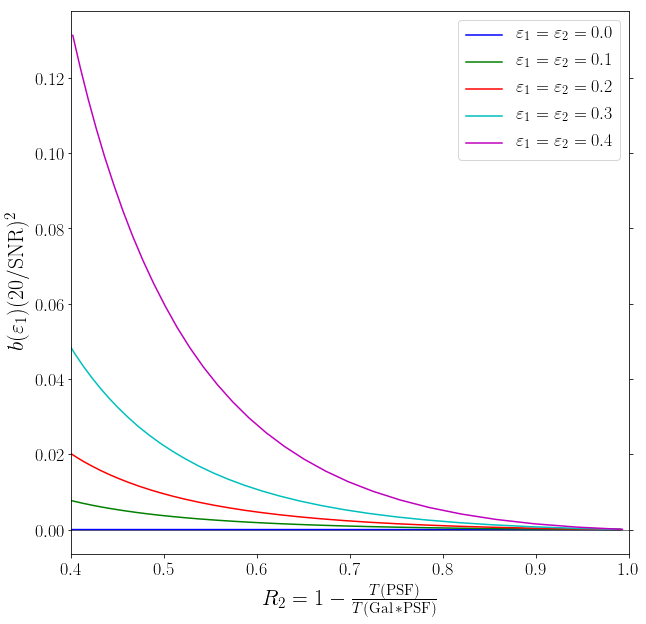

In [379]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size,['g1_1', 'e1_1'], vary = 'both', 
                  formatting = formatting1, plot_eps = True,  plot_chi = False )

### $\chi_{1}$ bias with $\varepsilon_{1} = \varepsilon_{2}$ in range $R_{2} = (0.4, 1.0)$

In [380]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [381]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-3}] $'
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.4,1.0) , ylim = None, vary = 'both', 
                             check_sci = 'yes', dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 18)

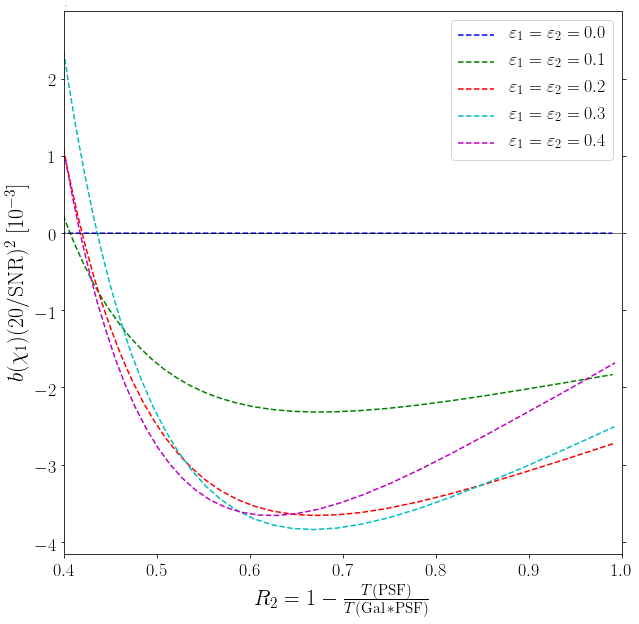

In [382]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'], 
                  formatting = formatting1, plot_eps = False,  plot_chi = True )


### $\varepsilon_{1}$ bias with $\varepsilon_{1} \neq 0, \varepsilon_{2} = 0 $ in range $R_{2} = (0.4, 1.0)$

In [35]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [36]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T({\\rm Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-3}]$'
formatting1 = get_formatting(xlabel, ylabel, gs,  vary = 'g1', xlim = (0.4,1.0) , ylim = (-0.005, .06), 
                             check_sci = 'specific 10e2', dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 18)

['$-10$', '$0$', '$10$', '$20$', '$30$', '$40$', '$50$', '$60$']


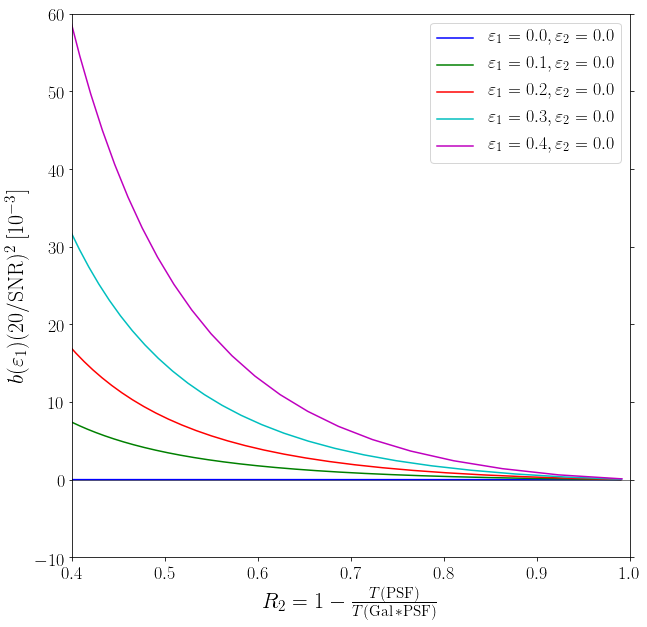

In [37]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size,['g1_1', 'e1_1'], vary = 'g1', 
                  formatting = formatting1, plot_eps = True,  plot_chi = False )

### $\chi_{1}$ bias with $\varepsilon_{1} \neq 0, \varepsilon_{2} = 0 $ in range $R_{2} = (0.4, 1.0)$

In [20]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [21]:
xlabel = '$R_{2} = 1 - {\\sigma^{2}_{+}\\left(\\rm{PSF}\\right) \\over \\sigma^{2}_{+}\\left(\\rm{Gal} \\ast \\rm{PSF}\\right) }'
ylabel = '$b(\\chi_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-3}]$'
formatting1 = get_formatting(xlabel, ylabel, gs,  vary = 'g1', xlim = (0.4,1.0) , ylim = (-.006,.004), 
                             check_sci = 'yes', dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 18)

In [22]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size,['g1_1', 'e1_1'], vary = 'g1', 
                  formatting = formatting1, plot_eps = False,  plot_chi = True )

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x111f7cd08> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$R_{2} = 1 - {\\\\sigma^{2}_{+}\\\\left(\\\\rm{PSF}\\\\right) \\\\over \\\\sigma^{2}_{+}\\\\left(\\\\rm{Gal} \\\\ast \\\\rm{PSF}\\\\right) }'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/Ismael/.matplotlib/tex.cache/c6628f874d675d3b7120b369c1a16b51.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file c6628f874d675d3b7120b369c1a16b51.aux.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.13 ..._{+}\left(\rm{Gal} \ast \rm{PSF}\right) }}
                                                  
No pages of output.
Transcript written on c6628f874d675d3b7120b369c1a16b51.log.




RuntimeError: latex was not able to process the following string:
b'$R_{2} = 1 - {\\\\sigma^{2}_{+}\\\\left(\\\\rm{PSF}\\\\right) \\\\over \\\\sigma^{2}_{+}\\\\left(\\\\rm{Gal} \\\\ast \\\\rm{PSF}\\\\right) }'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/Ismael/.matplotlib/tex.cache/c6628f874d675d3b7120b369c1a16b51.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./c6628f874d675d3b7120b369c1a16b51.aux)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.13 ..._{+}\left(\rm{Gal} \ast \rm{PSF}\right) }}
                                                  
No pages of output.
Transcript written on c6628f874d675d3b7120b369c1a16b51.log.




<Figure size 720x720 with 1 Axes>

### $\varepsilon_{1}$ bias with $\varepsilon_{1} = \varepsilon_{2} = \varepsilon / \sqrt{2} $ in range $R_{2} = (0.4, 1.0)$

In [22]:
starts = [.275,.27,.255, .230,.2] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 5)
gs = np.linspace(0, .4, 5 ) / np.sqrt(2)
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.          0.07071068  0.14142136  0.21213203  0.28284271]


In [23]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T({\\rm Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2}$'
formatting1 = get_formatting(xlabel, ylabel, gs,  vary = 'both', xlim = (0.4,1.0) , ylim = None, 
                             check_sci = True, dash_and_solid = False, hline = (0,0.5, 'black'), legend_size = 18, lg_precision = 2)

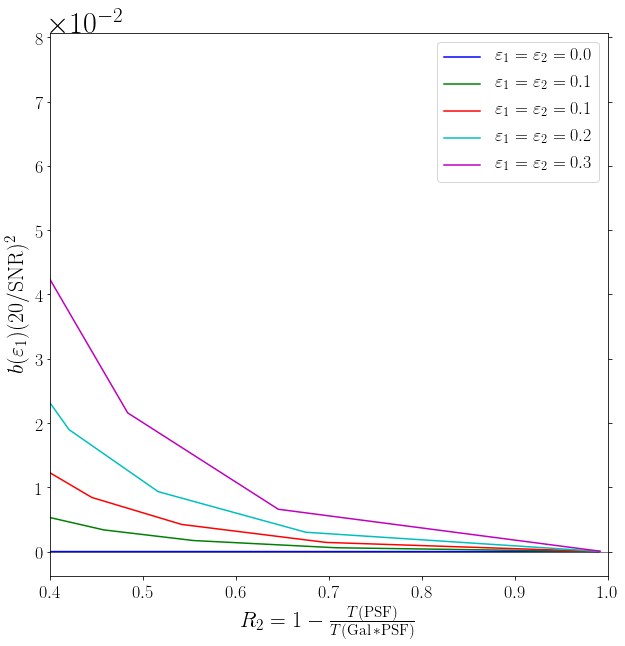

In [24]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size,['g1_1', 'e1_1'], vary = 'both', 
                  formatting = formatting1, plot_eps = True,  plot_chi = False )

### $\chi_{1}$ bias with $\varepsilon_{1} = \varepsilon_{2} = \varepsilon / \sqrt{2} $ in range $R_{2} = (0.4, 1.0)$



## together 

### Both biases $\varepsilon_{1}, \chi_{1}$ in  $R \in (0.6, 1.0)$ with $\varepsilon_{1} = \varepsilon_{2} $ 

In [50]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [51]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{1}), b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'

In [53]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = None, vary = 'both', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

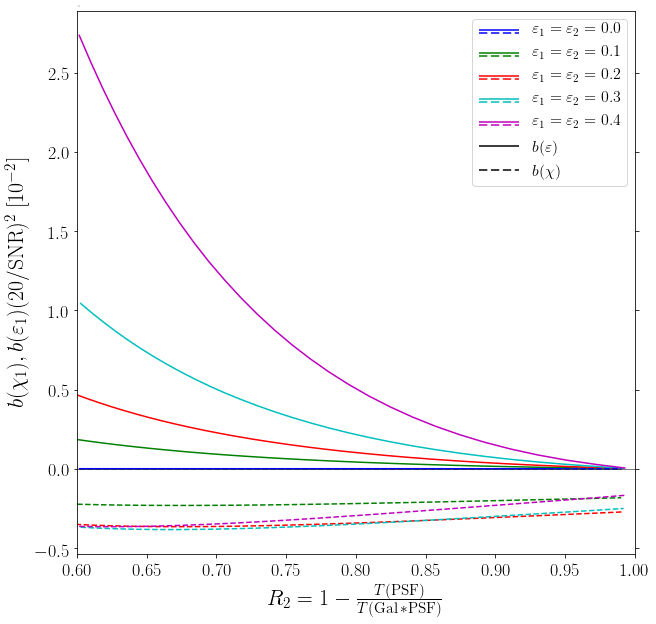

In [442]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True )




### Both biases $\varepsilon_{2}, \chi_{2}$ in $R \in (0.6, 1.0)$ with $\varepsilon_{1} = \varepsilon_{2} $ 

In [287]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 120 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [288]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{2}), b(\\varepsilon_{2}) (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'

In [289]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = None, vary = 'both', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

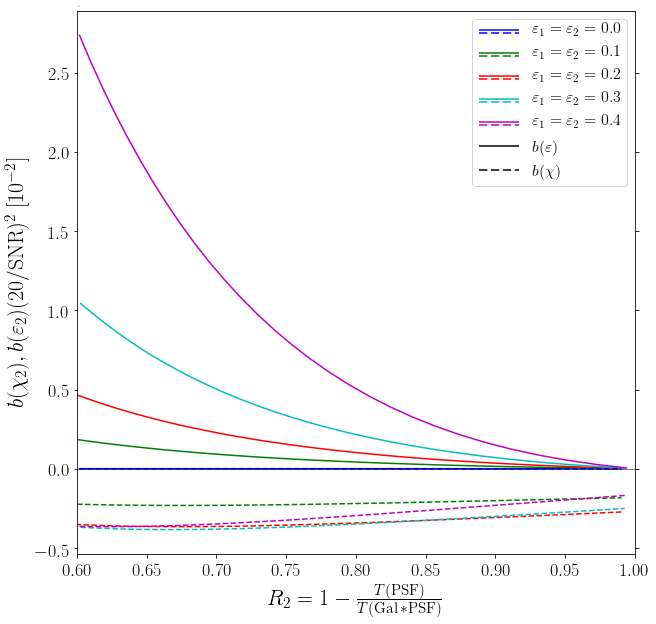

In [290]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g2_1', 'e2_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True )


### $\varepsilon_{1}$, $\chi_{1}$ bias with $\varepsilon_{1} \neq 0, \varepsilon_{2} = 0 $ in range $R_{2} = (0.6, 1.0)$

In [283]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 130 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [284]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{1}), b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'

In [285]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = (-0.006,.015), vary = 'g1', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

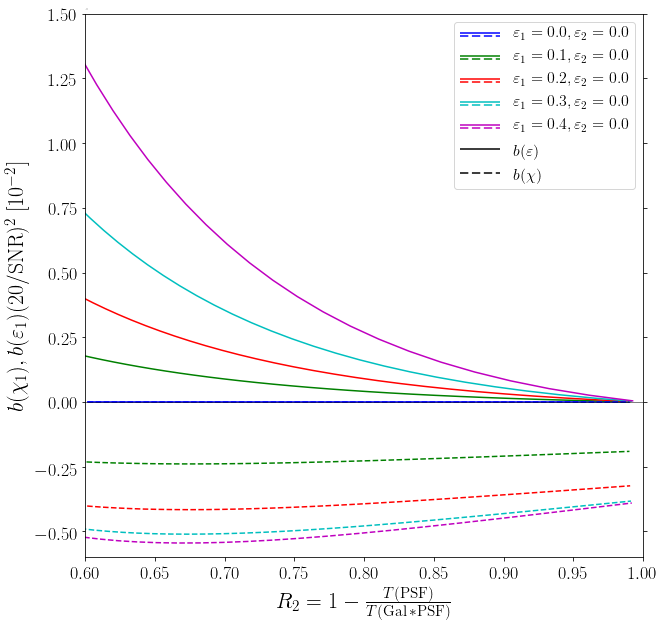

In [286]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'],vary = 'g1', 
                  formatting = formatting1, plot_eps = True,  plot_chi = True )

### $\varepsilon_{2}$, $\chi_{2}$ bias with $\varepsilon_{2} \neq 0, \varepsilon_{1} = 0 $ in range $R_{2} = (0.6, 1.0)$

In [230]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [231]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{2}), b(\\varepsilon_{2}) (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'

In [232]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = (-0.006,.015), vary = 'g2', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

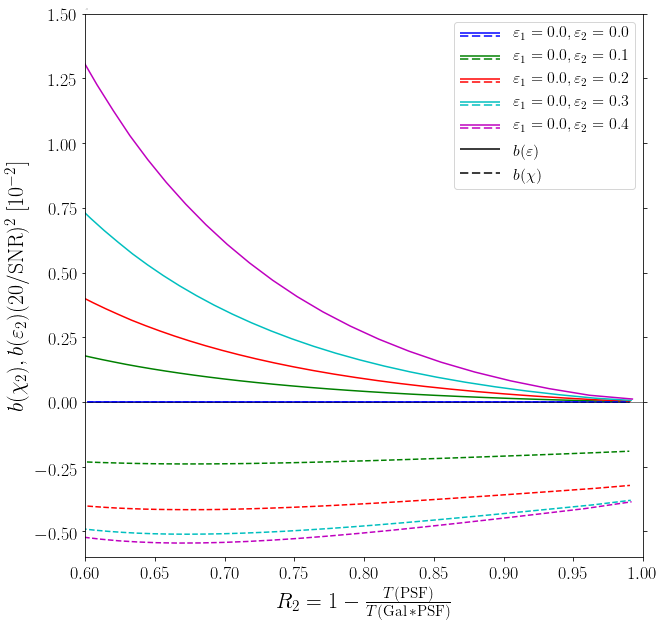

In [233]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g2_1', 'e2_1'],vary = 'g2', 
                  formatting = formatting1, plot_eps = True,  plot_chi = True )

### $\varepsilon_{1}$, $\chi_{1}$ bias with $\varepsilon_{2} \neq 0, \varepsilon_{1} = 0 $ in range $R_{2} = (0.6, 1.0)$

In [31]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [32]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{1}), b(\\varepsilon_{1}) (20 / \\rm{SNR})^{2} \\; [10^{-7}]$'

In [33]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = None, vary = 'g2', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

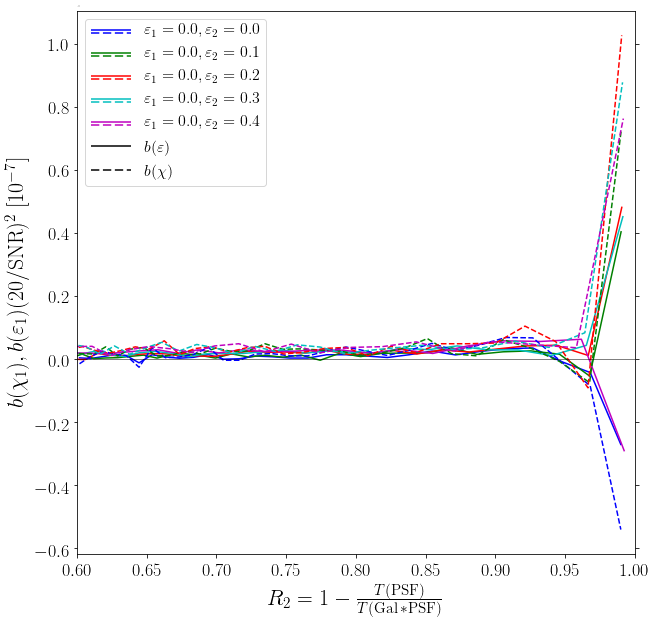

In [34]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True, vary = 'g2')

### $\varepsilon_{2}$, $\chi_{2}$ bias with $\varepsilon_{1} \neq 0, \varepsilon_{2} = 0 $ in range $R_{2} = (0.6, 1.0)$

In [106]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

[ 0.   0.1  0.2  0.3  0.4]


In [107]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{2}), b(\\varepsilon_{2}) (20 / \\rm{SNR})^{2} \\; [10^{-7}]$'

In [108]:
formatting1 = get_formatting(xlabel, ylabel,gs,  xlim = (0.6,1.0) , ylim = None, vary = 'g1', 
                             check_sci = 'specific 1e7', dash_and_solid = True, hline = (0,0.5, 'black'), legend_size = 16)

['$0.0$', '$0.1$', '$0.2$', '$0.3$', '$0.4$', '$0.5$', '$0.6$', '$0.7$', '$0.8$', '$0.9$']


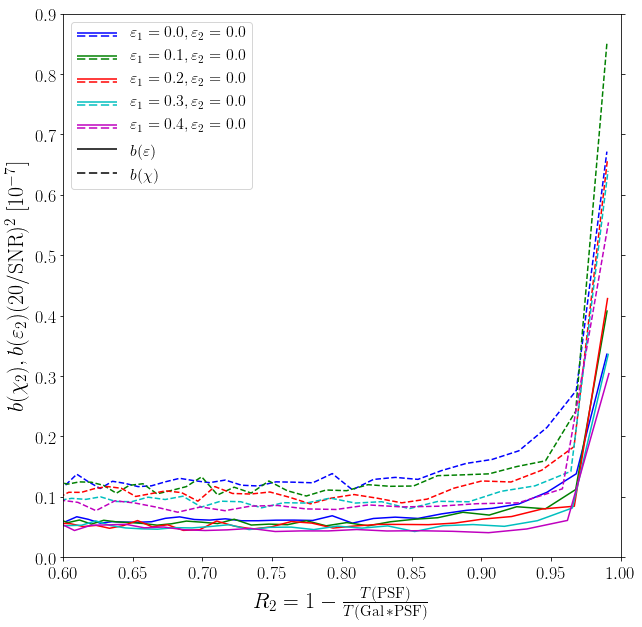

In [109]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g2_1', 'e2_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True, vary = 'g1')

###  $\rm{sgn} \sqrt{b(\varepsilon_{1})^2 + b(\varepsilon_{2})^2}$ bias with $\varepsilon_{1} = \varepsilon_{2} = \varepsilon / \sqrt{2}$ in range $R_{2} = (0.6, 1.0)$

In [56]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )/ np.sqrt(2)
img_size = 120 
#print(hlrss)
print 
print(gs)

[ 0.          0.07071068  0.14142136  0.21213203  0.28284271]


In [57]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '\\rm{sgn}$(e_{1,2})\\sqrt{b(e_{1})^2 + b(e_{2})^2} \\; (20 / \\rm{SNR})^{2} \\; [10^{-2}]$'

In [58]:
formatting1 = get_formatting(xlabel, ylabel,gs, xlim = (0.6,1.0) , ylim = (-.007, .015), vary = 'both', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), 
                             legend_size = 16, lg_precision = 2 )


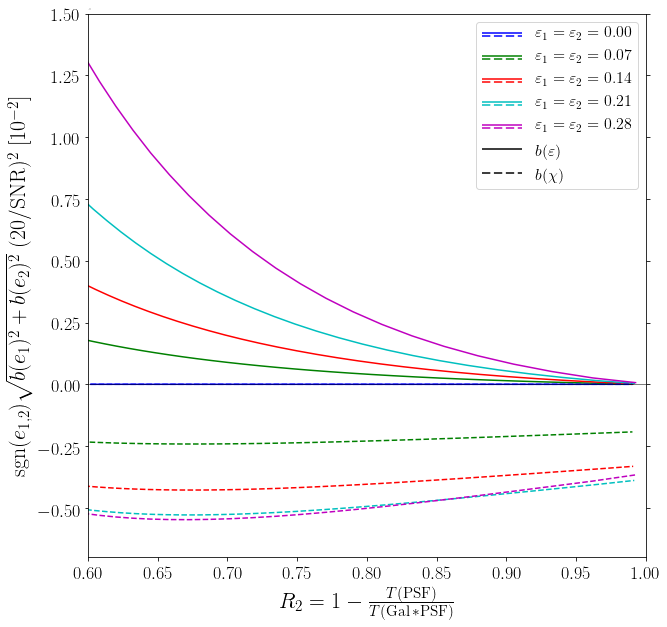

In [59]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'g2_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True, 
                  vary = 'both', sqrt = True, lg_precision =2 )

###  $b(\varepsilon_{1}), b(\chi_{1})$ bias with $\varepsilon_{1} = \varepsilon_{2} = \varepsilon / \sqrt{2}$ in range $R_{2} = (0.6, 1.0)$

In [304]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )/ np.sqrt(2)
img_size = 120 
#print(hlrss)
print 
print(gs)

[ 0.          0.07071068  0.14142136  0.21213203  0.28284271]


In [305]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{1}), b(\\varepsilon_{1}) \\; (20 / \\rm{SNR})^{2} \\; [10^-2]$'

In [306]:
formatting1 = get_formatting(xlabel, ylabel,gs, xlim = (0.6,1.0) , ylim = (-.007, .015), vary = 'both', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), 
                             legend_size = 16, lg_precision = 2 )

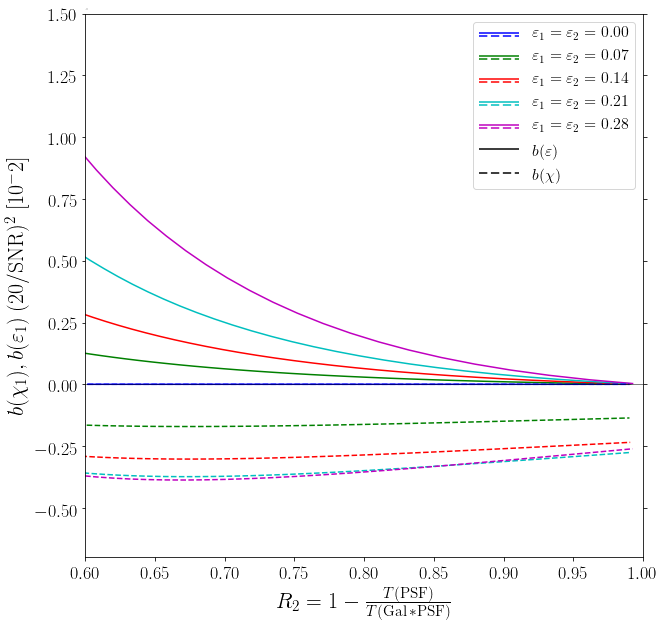

In [307]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g1_1', 'e1_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True, 
                  vary = 'both', lg_precision =2 , sqrt= False)

###  $b(\varepsilon_{2}), b(\chi_{2})$ bias with $\varepsilon_{1} = \varepsilon_{2} = \varepsilon / \sqrt{2}$ in range $R_{2} = (0.6, 1.0)$

In [308]:
starts = [.425, .415, .390, 0.355,.305] #manually find the starting points. 
hlrss = prepare_hlrss_nlinear(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )/ np.sqrt(2)
img_size = 120 
#print(hlrss)
print 
print(gs)

[ 0.          0.07071068  0.14142136  0.21213203  0.28284271]


In [309]:
xlabel = '$R_{2} = 1 - \\frac{T(\\rm{PSF})}{T(\\rm{Gal} \\, \\ast \\rm{PSF})}$'
ylabel = '$b(\\chi_{2}), b(\\varepsilon_{2}) \\; (20 / \\rm{SNR})^{2} \\; [10^-2]$'

In [310]:
formatting1 = get_formatting(xlabel, ylabel,gs, xlim = (0.6,1.0) , ylim = (-.007, .015), vary = 'both', 
                             check_sci = 'yes', dash_and_solid = True, hline = (0,0.5, 'black'), 
                             legend_size = 16, lg_precision = 2 )

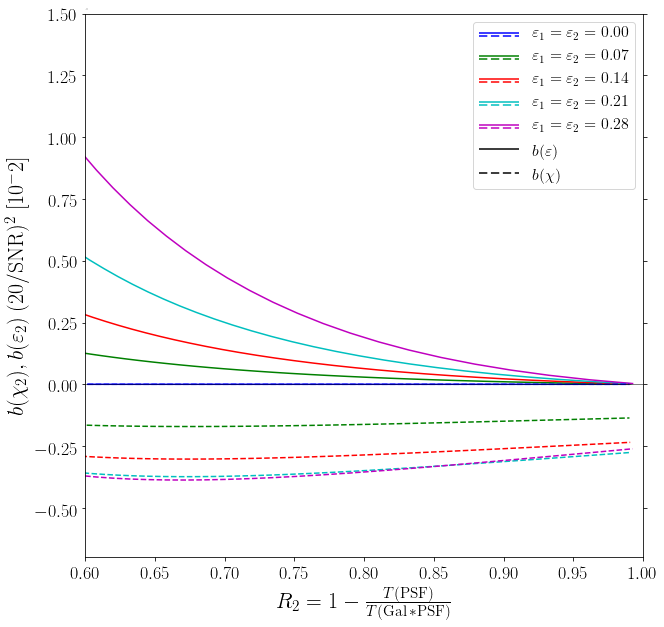

In [311]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, ['g2_1', 'e2_1'],
                  formatting = formatting1, plot_eps = True,  plot_chi = True, 
                  vary = 'both', lg_precision =2 , sqrt= False)

# Testing plotting

In [ ]:
starts = [.530, .520, .49, 0.4425,.38] #manually find the starting points. 
hlrss = prepare_hlrss(starts, 3.5, 30)
gs = np.linspace(0, .4, 5 )
img_size = 100 
#print(hlrss)
print 
print(gs)

In [ ]:
plot_size_vs_bias(g_parameters1, g_parameters2, hlrss, gs, colors, img_size, 
                  formatting = formatting2, plot_eps = True,  plot_chi = True )



In [202]:
hlrs = np.linspace(0.2, 1, 30)
g = 0.3

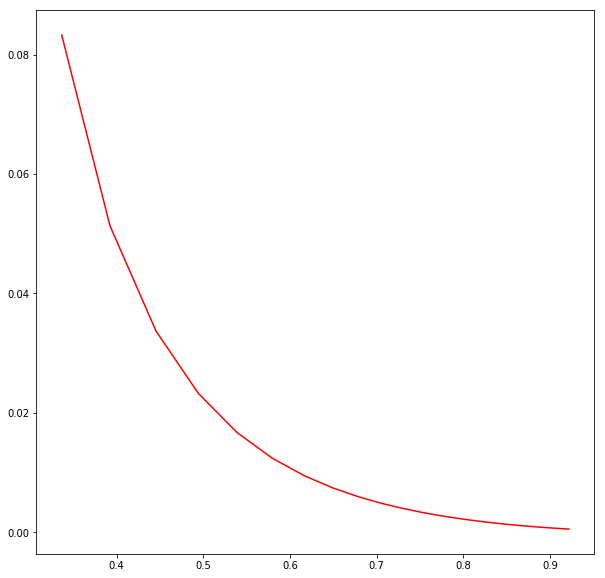

In [203]:
single_eps_plot(g, hlrs, g_parameters1, img_size)



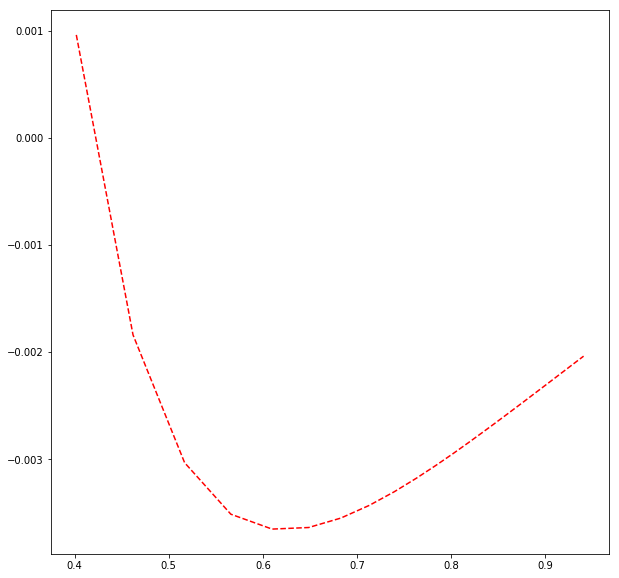

In [166]:
single_chi_plot(g, hlrs, g_parameters1, img_size)


# Miscallenous plotting

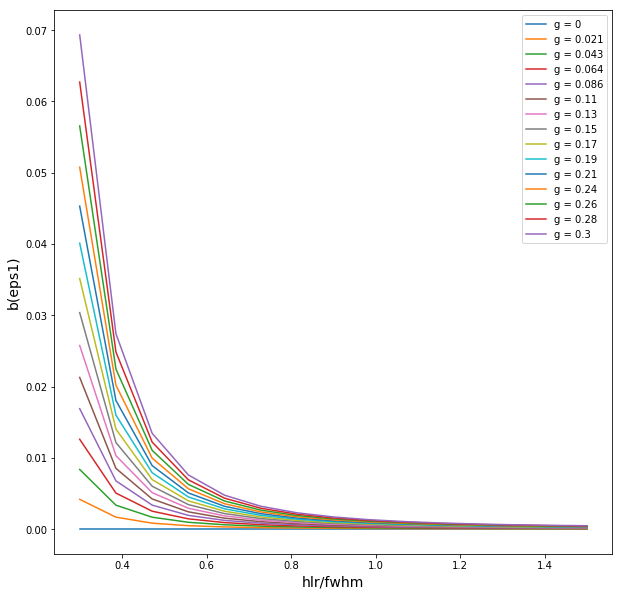

In [30]:
#vary both g1, g2 
from copy import deepcopy
plt.figure(figsize=(10, 10))
for g in np.linspace(0,.3, 15):
    bias = []
    hlr_fwhms = np.linspace(.3, 1.5, 15)
    hlrs = hlr_fwhms *g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(hlr_fwhms, bias, label = f"g = {g:.2g}")
plt.ylabel('b(eps1)', size = 14)
plt.xlabel('hlr/fwhm' , size = 14 )
plt.legend(loc = 'best')

In [20]:
print(g_parameters1.id_params)
print(g_parameters2.id_params)

{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'psf_gaussian'), ('x0', 0.0), ('g2', 0.0), ('y0', 0.0), ('flux', 1.0), ('hlr', 1.0), ('g1', 0.2), ('psf_flux', 1.0), ('psf_fwhm', 0.7)])}
{'1': OrderedDict([('galaxy_model', 'gaussian'), ('psf_model', 'psf_gaussian'), ('x0', 0.0), ('y0', 0.0), ('flux', 1.0), ('e2', 0.1), ('hlr', 1.0), ('e1', 0.1), ('psf_fwhm', 0.7), ('psf_flux', 1.0)])}


In [43]:
np.linspace(0,0.5, 6)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

KeyboardInterrupt: 

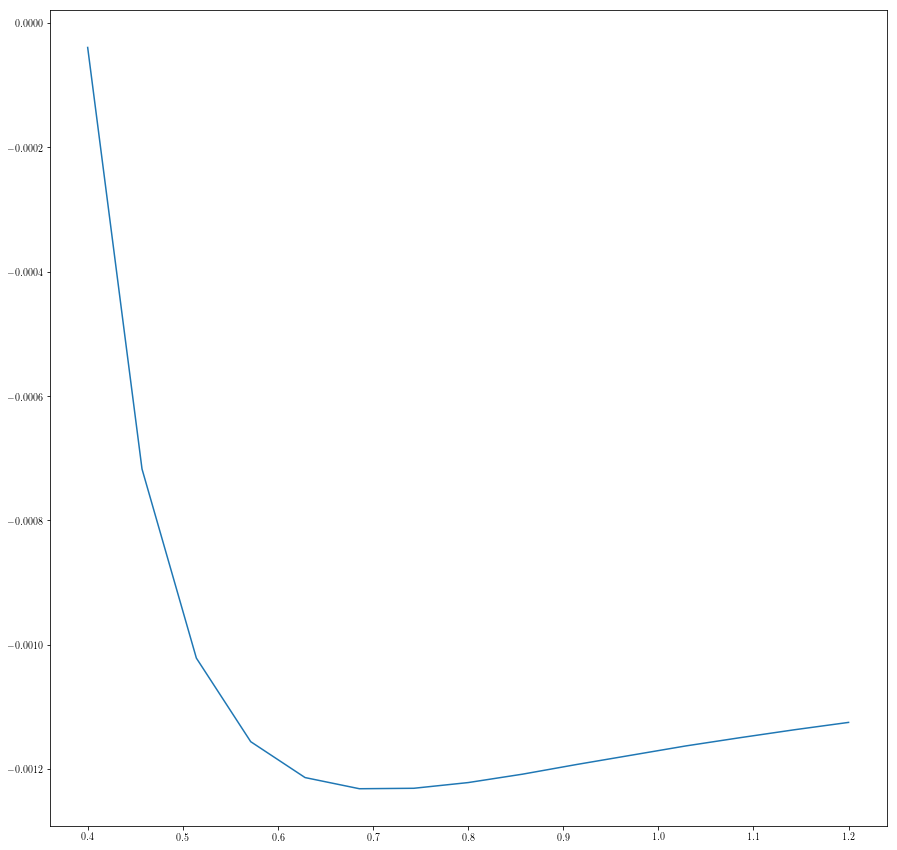

In [27]:
from copy import deepcopy
plt.figure(figsize=(15, 15))
for g in np.linspace(0.05,.15, 20):
    e = galsim.shear.Shear(g1 = g, g2=g).e1
    bias = []
    hlr_fwhms = np.linspace(.4, 1.2, 15)
    hlrs = hlr_fwhms *g_parameters2.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e; id_params_new['1']['e2'] = e; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(hlr_fwhms, bias, label = f"g = {g:.2g}")
plt.ylabel('b(e1)', size = 14)
plt.xlabel('hlr/fwhm' , size = 14 )
plt.legend(loc = 'best',prop={'size': 15})

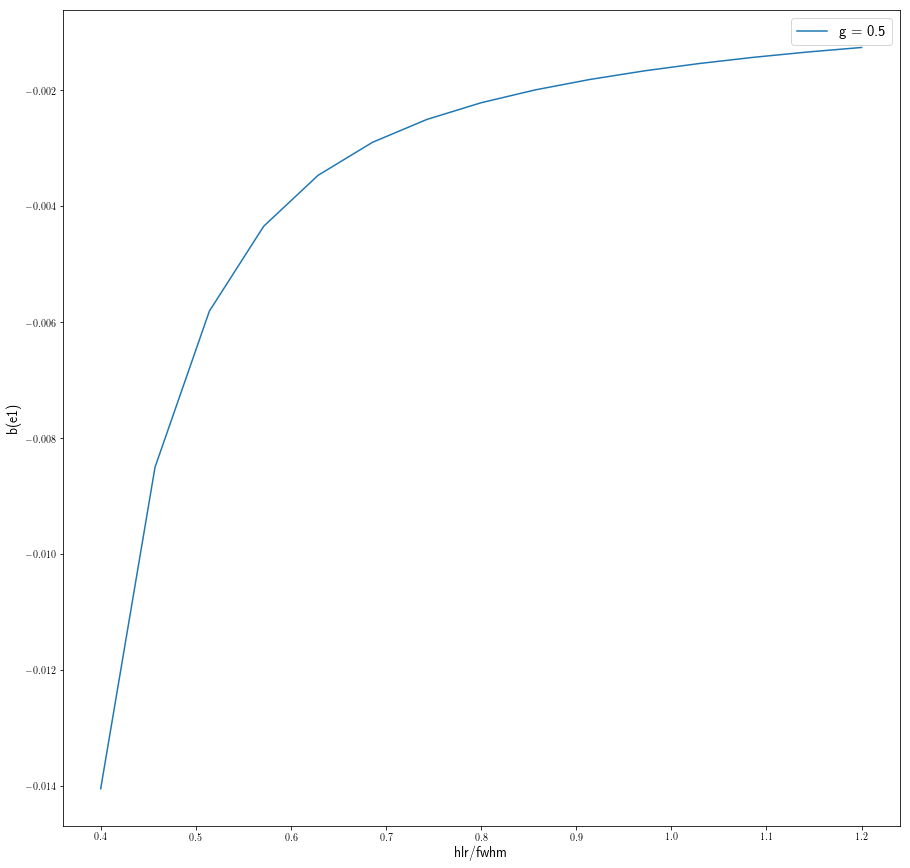

In [41]:
from copy import deepcopy
plt.figure(figsize=(15, 15))
g = .5
e = galsim.shear.Shear(g1 = g, g2=g).e1
bias = []
hlr_fwhms = np.linspace(.4, 1.2, 15)
hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
for hlr in hlrs:
    id_params_new = deepcopy(g_parameters2.id_params)
    id_params_new['1']['e1'] = e; id_params_new['1']['e2'] = e; id_params_new['1']['hlr'] = hlr
    new_g_parameters = galfun.GParameters(id_params= id_params_new)
    new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
    bias.append(new_fish.biases['e1_1'])
plt.plot(hlr_fwhms, bias, label = f"g = {g:.2g}")
plt.ylabel('b(e1)', size = 14)
plt.xlabel('hlr/fwhm' , size = 14 )
plt.legend(loc = 'best',prop={'size': 15})

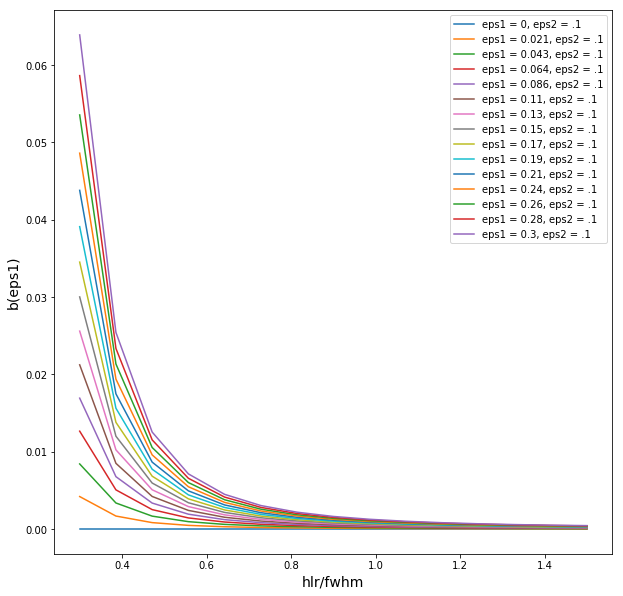

In [33]:
#vary only g1; g2  = .1 
from copy import deepcopy
plt.figure(figsize=(10, 10))
for g in np.linspace(0,.3, 15):
    bias = []
    hlr_fwhms = np.linspace(.3, 1.5, 15)
    hlrs = hlr_fwhms *g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g2']  = .1 
        id_params_new['1']['g1'] = g;  id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(hlr_fwhms, bias, label = f"eps1 = {g:.2g}, eps2 = .1")
plt.ylabel('b(eps1)', size = 14)
plt.xlabel('hlr/fwhm' , size = 14 )
plt.legend(loc = 'best')

In [7]:
g_parameters1.id_params

{'1': OrderedDict([('galaxy_model', 'gaussian'),
              ('psf_model', 'psf_gaussian'),
              ('y0', 0.0),
              ('x0', 0.0),
              ('g2', 0.1),
              ('g1', 0.1),
              ('flux', 1.0),
              ('hlr', 1.0),
              ('psf_fwhm', 0.7),
              ('psf_flux', 1.0)])}

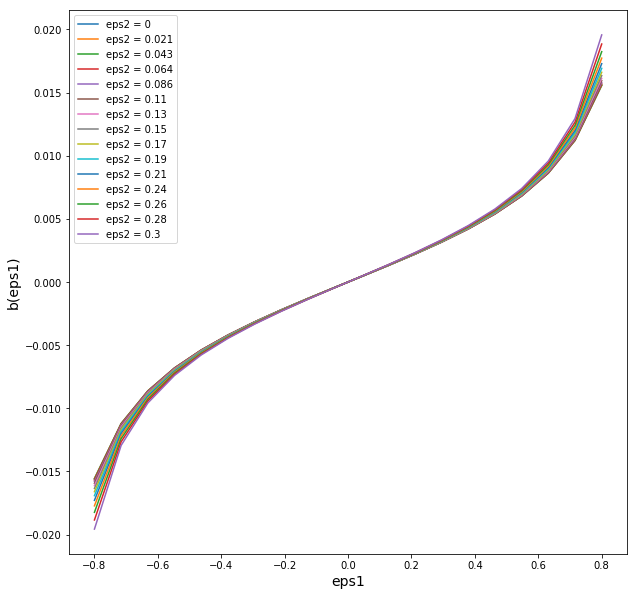

In [18]:
#vary both g1,g2; look at bias. hlr = 0.5 
g_parameters1.id_params['1']['hlr'] = 0.5 
from copy import deepcopy
plt.figure(figsize=(10, 10))
for g2 in np.linspace(0,.3, 15):
    bias = []
    g1s = np.linspace(-0.8, 0.8, 20)
    for g1 in g1s:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1']  = g1
        id_params_new['1']['g2'] = g2
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(g1s, bias, label = f"eps2 = {g2:.2g}")
plt.ylabel('b(eps1)', size = 14)
plt.xlabel('eps1' , size = 14 )
plt.legend(loc = 'best')

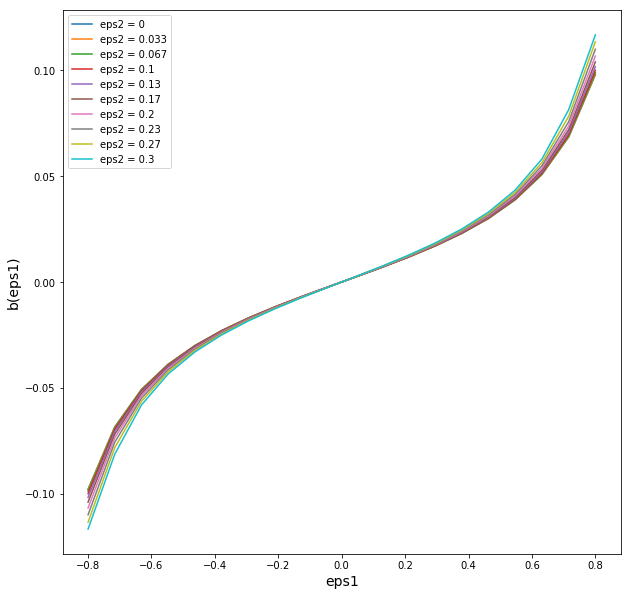

In [22]:
#vary both g1,g2; look at bias. hlr = 1
g_parameters1.id_params['1']['hlr'] = .3 
from copy import deepcopy
plt.figure(figsize=(10, 10))
for g2 in np.linspace(0,.3, 10):
    bias = []
    g1s = np.linspace(-0.8, 0.8, 20)
    for g1 in g1s:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1']  = g1
        id_params_new['1']['g2'] = g2
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(g1s, bias, label = f"eps2 = {g2:.2g}")
plt.ylabel('b(eps1)', size = 14)
plt.xlabel('eps1' , size = 14 )
plt.legend(loc = 'best')

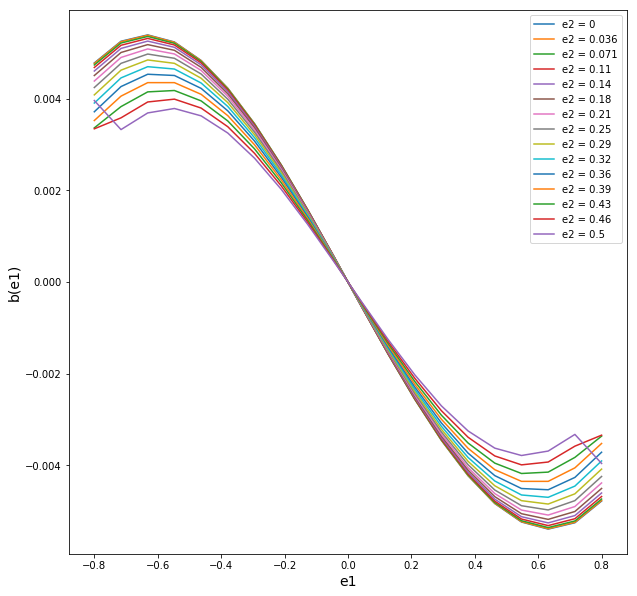

In [16]:
#vary only g1; g2  = .1 
g_parameters2.id_params['1']['hlr'] = 0.5 
from copy import deepcopy
plt.figure(figsize=(10, 10))
for e2 in np.linspace(0,.5, 15):
    bias = []
    e1s = np.linspace(-0.8, 0.8, 20)
    for e1 in e1s:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1']  = e1
        id_params_new['1']['e2'] = e2
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(e1s, bias, label = f"e2 = {e2:.2g}")
plt.ylabel('b(e1)', size = 14)
plt.xlabel('e1' , size = 14 )
plt.legend(loc = 'best')

Text(0.5,0,'eps1')

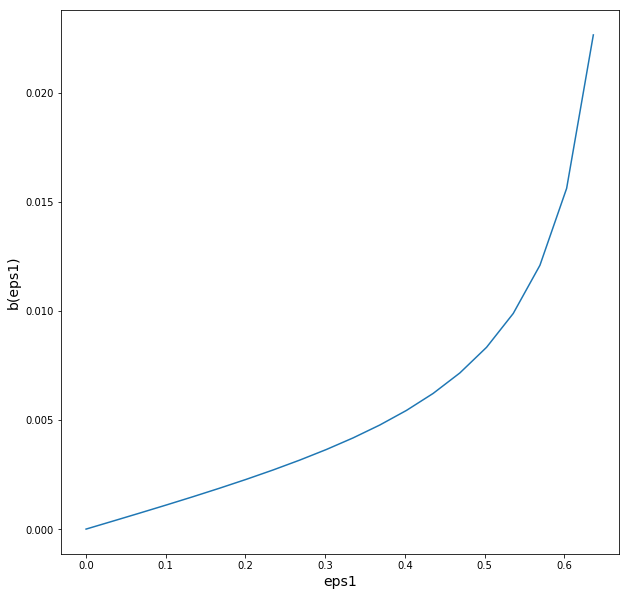

In [5]:
#vary both g1,g2; look at bias. hlr = 1
g_parameters1.id_params['1']['hlr'] = .49
from copy import deepcopy
plt.figure(figsize=(10, 10))
gs = np.linspace(0,0.9, 20)
bias = [] 
for g in gs:
    g1 = g2 = g / np.sqrt(2)
    id_params_new = deepcopy(g_parameters1.id_params)
    id_params_new['1']['g1']  = g1
    id_params_new['1']['g2'] = g2
    new_g_parameters = galfun.GParameters(id_params= id_params_new)
    new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
    bias.append(new_fish.biases['g1_1'])
plt.plot(gs/np.sqrt(2), bias) 
plt.ylabel('b(eps1)', size = 14)
plt.xlabel('eps1' , size = 14 )

# HLR /FWHM vs. bias 

In [ ]:
from copy import deepcopy
plt.rc('text', usetex=True)


In [64]:
image_renderer = galfun.ImageRenderer(pixel_scale=.2, nx=150,ny=150)

## Plots using HLR/ FWHM 

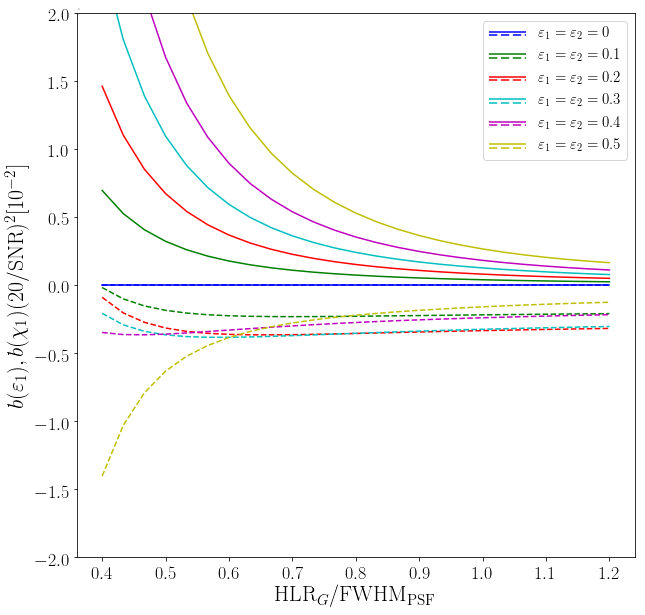

In [36]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    hlr_fwhms = np.linspace(.4, 1.2, 25)
    hlrs = hlr_fwhms * g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(hlr_fwhms, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []
    hlr_fwhms = np.linspace(.4, 1.2, 25)
    hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
    
    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(hlr_fwhms, bias, '--', color = c )
    
plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'\rm HLR$_{G}$/FWHM$_{\rm PSF}$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

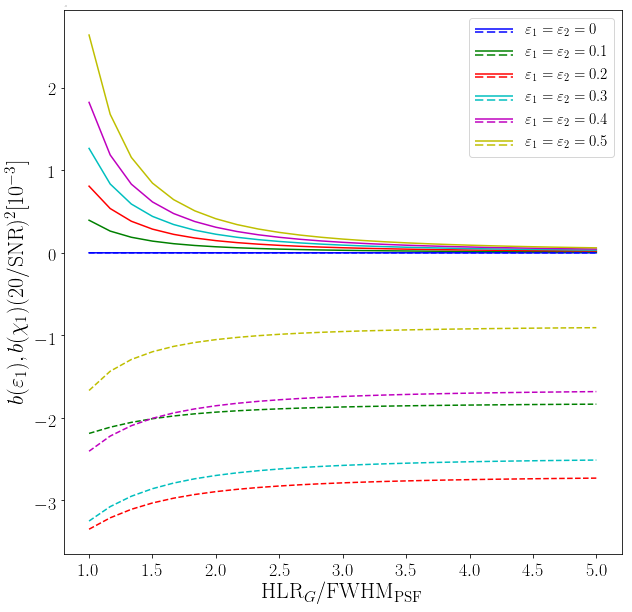

In [27]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    hlr_fwhms = np.linspace(1, 5, 25)
    hlrs = hlr_fwhms * g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(hlr_fwhms, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []
    hlr_fwhms = np.linspace(1, 5, 25)
    hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
    
    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(hlr_fwhms, bias, '--', color = c )
    
#plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-3}]$', size = 22)
plt.xlabel(r'\rm HLR$_{G}$/FWHM$_{\rm PSF}$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

## New plots using R =  1 - size(PSF)^2 / [size(PSF)^2 + size(gal)^2]

In [42]:
psf = galsim.Gaussian(fwhm = g_parameters1.id_params['1']['psf_fwhm'])
hlr_psf =psf.half_light_radius

In [54]:
Rs = np.linspace(0.6, 0.9, 10 )
gal_hlrs = np.sqrt((hlr_psf**2 / ( 1 - Rs))  - hlr_psf**2 ) 
gal_hlrs

array([ 0.4286607 ,  0.45999012,  0.49497475,  0.53463383,  0.58040934,
        0.63442888,  0.7       ,  0.78262379,  0.89232841,  1.05      ])

In [ ]:
gs = np.linspace(0,0.5, 6)

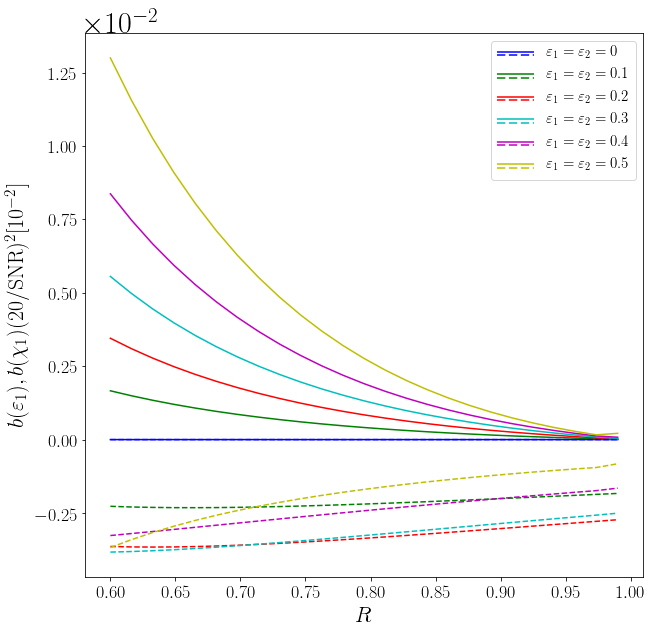

In [47]:


Rs = np.linspace(0.6, 0.99, 25 )
gal_hlrs = np.sqrt((hlr_psf**2 / ( 1 - Rs))  - hlr_psf**2 ) 
    



for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []

    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(Rs, bias, '--', color = c )
    
#plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

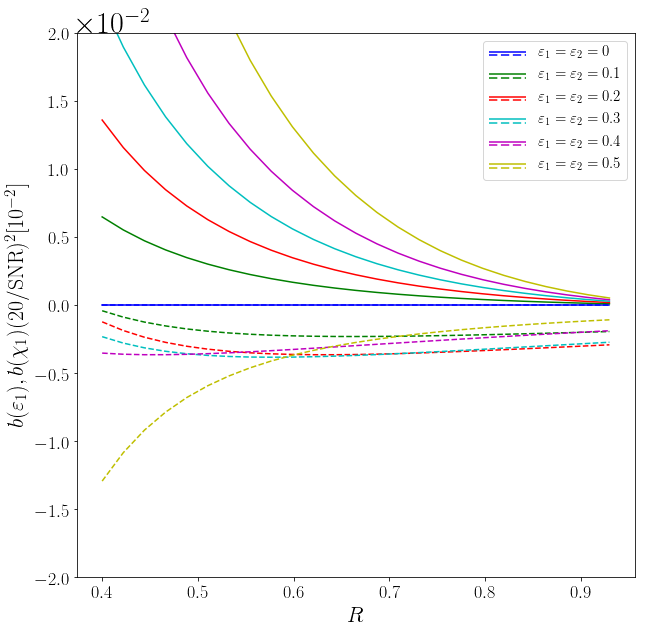

In [56]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

Rs = np.linspace(0.4, 0.93,25 )
gal_hlrs = np.sqrt((hlr_psf**2 / ( 1 - Rs))  - hlr_psf**2 ) 
    
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(Rs, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []

    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(Rs, bias, '--', color = c )
    
plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

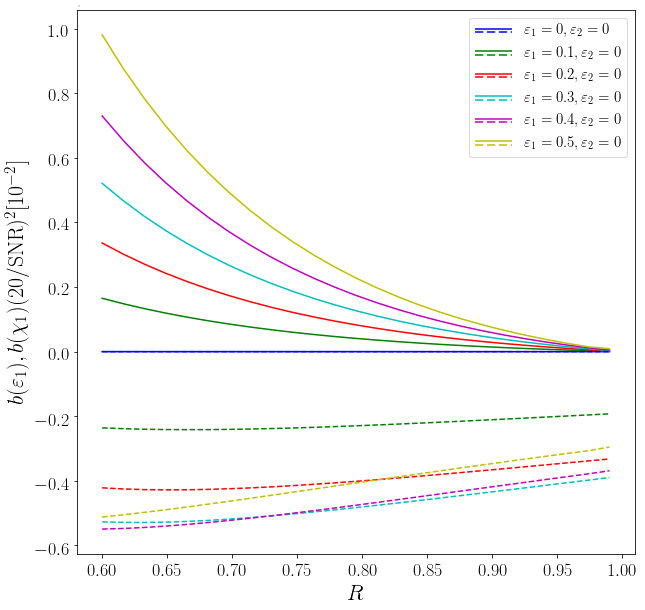

In [62]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

Rs = np.linspace(0.6, 0.99, 25 )
gal_hlrs = np.sqrt((hlr_psf**2 / ( 1 - Rs))  - hlr_psf**2 ) 
    
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = 0; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(Rs, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []

    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = 0 )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = 0; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(Rs, bias, '--', color = c )
    
#plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = {g:.2g} , \\varepsilon_{2} = 0$ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

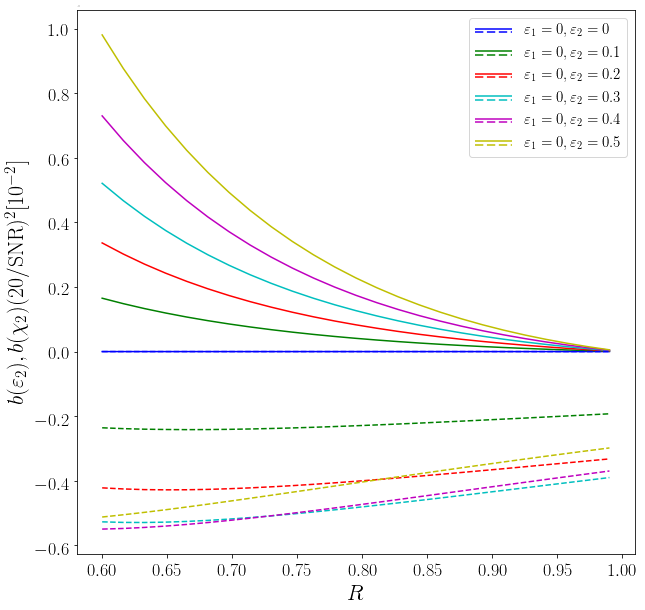

In [63]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

Rs = np.linspace(0.6, 0.99, 25 )
gal_hlrs = np.sqrt((hlr_psf**2 / ( 1 - Rs))  - hlr_psf**2 ) 
    
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = 0; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g2_1'])
    plt.plot(Rs, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []

    #get corresponding e 
    shr = galsim.shear.Shear(g1 = 0, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in gal_hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = 0; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e2_1'])
    plt.plot(Rs, bias, '--', color = c )
    
#plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{2}), b(\\chi_{2}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(1)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines: 
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = 0 , \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)

plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

## Using second moments measurement 

In [15]:
image_renderer = galfun.ImageRenderer(pixel_scale=.2, nx=200,ny=200)

In [ ]:
#check size of postage stamp is enough based on Pat's comment. 
for g in np.linspace(0, 0.5, 6): 
    

In [ ]:
#plot of HLR and R2 from different for different \epsilons. 


### Test to get a sense of R2


In [18]:
g = 0.5
hlr = .2
id_params_new = deepcopy(g_parameters1.id_params)
id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
new_g_parameters = galfun.GParameters(id_params= id_params_new)
new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
print(get_R2(new_fish,psf_T))

0.504693021112


In [ ]:
hlr_min = 0.3; hlr_max = 3.3

In [ ]:
def get_hlr(R2, psf_T, err, hlr_min, hlr_max): 
    curr_hlr = .1 
    
    curr_fish = 
    err = R2 - get_rd
    while err
    

### Plots 

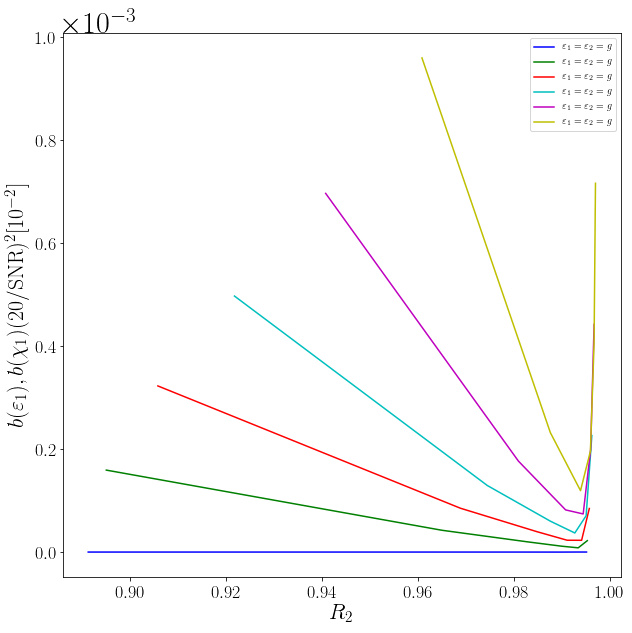

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))


for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    Rs = []
    hlrs = np.linspace(1, 5, 6)
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        R2 = 1 - psf_T / (2 * new_fish.model.calculateMomentRadius(size = 150, scale = .2 ,rtype= 'trace')**2 ) 
        bias.append(new_fish.biases['g1_1'])
        Rs.append(R2)
    plt.plot(Rs, bias, color = c, label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g}$" )


# plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R_{2}$' , size = 22 )

#power limits. 
ax.get_yaxis().get_offset_text().set_size(30)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))

plt.tick_params(axis='both', which='major', labelsize=18)

plt.legend(loc = 'best',prop={'size': 15})

# #create double solid and dashed lines for legend.  
# line = [[(0, 0)]]
# #set up the line collections
# lines = [] 
# labels = [] 
# for g,color in zip(np.linspace(0,0.5, 6), colors): 
#     lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
#     label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
#     lines.append(lc)
#     labels.append(label)
# plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

# Miscellnaneous

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))


for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    Rs = []
    hlrs = np.linspace(1, 5, 25)
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        R = 1 - psf_T / (2 * new_fish.model.calculateMomentRadius(size = 300, scale = .2 ,rtype= 'trace')**2 ) 
        bias.append(new_fish.biases['g1_1'])
        Rs.append(R)
    plt.plot(Rs, bias, color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []
    Rs = [] 
    hlrs = np.linspace(1, 5, 25)
    
    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        R = 1 - psf_T / (2 * new_fish.model.calculateMomentRadius(size = 300, scale = .2 ,rtype= 'trace')**2 ) 
        bias.append(new_fish.biases['e1_1'])
        Rs.append(R)
    plt.plot(Rs, bias, '--', color = c )
    
# plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2} [10^{-2}]$', size = 22)
plt.xlabel(r'$R_{2}$' , size = 22 )

#power limits. 
ax.get_yaxis().get_offset_text().set_size(50)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))

plt.tick_params(axis='both', which='major', labelsize=18)

#create double solid and dashed lines for legend.  
line = [[(0, 0)]]
#set up the line collections
lines = [] 
labels = [] 
for g,color in zip(np.linspace(0,0.5, 6), colors): 
    lc = LineCollection(2 * line, linestyles = ['solid', 'dashed'], colors = [color, color])
    label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g} $ "
    lines.append(lc)
    labels.append(label)
plt.legend(lines, labels, loc = 'best',prop={'size': 15}, handler_map = {type(lc) : HandlerDashedLines()}, handlelength = 2.5)

Text(0.5,0,'\\rm HLR$_{G}$/FWHM$_{\\rm PSF}$')

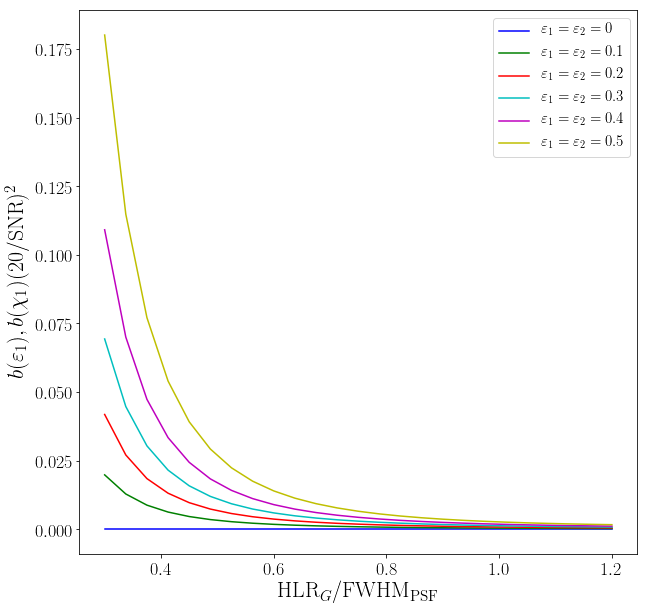

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    hlr_fwhms = np.linspace(.3, 1.2, 25)
    hlrs = hlr_fwhms * g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    ax.plot(hlr_fwhms, bias, label = f"$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g}$", color = c )
    
# ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
# ax.get_yaxis().get_offset_text().set_size(30)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(loc = 'best',prop={'size': 15})
ax.set_ylabel('$b(\\varepsilon_{1}), b(\\chi_{1}) (20 / \\rm{SNR})^{2}$', size = 22)
ax.set_xlabel(r'\rm HLR$_{G}$/FWHM$_{\rm PSF}$' , size = 22 )


# plt.ylim(-.02, .02)
# plt.ylabel('$b(\\varepsilon_{1}) / b(\\chi_{1}) [10^{-2}]$', size = 22)
# plt.xlabel(r'\rm HLR/FWHM$_{\rm PSF}$' , size = 22 )



In [25]:
fig, ax= plt.subplots(figsize=(10, 10))


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []
    hlr_fwhms = np.linspace(.4, 1.2, 10)
    hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
    
    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    ax.plot(hlr_fwhms, bias, '--', color = c ,  label = f"$$\\varepsilon_{1} = \\varepsilon_{2} = {g:.2g}$")
    
plt.legend(loc = 'best',prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('$b(\\varepsilon_{1}) / b(\\chi_{1})$', size = 22)
ax.set_xlabel(r'\rm HLR$_{G}$/FWHM$_{\rm PSF}$' , size = 22 )
ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
ax.get_yaxis().get_offset_text().set_size(30)




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1104bc268> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$$\\\\varepsilon_1 = \\\\varepsilon_2 = 0$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/Ismael/.matplotlib/tex.cache/79493f67f9d7bad6fedf77085556a23a.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 79493f67f9d7bad6fedf77085556a23a.aux.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Display math should end with $$.
<to be read again> 
                   }
l.13 ...mily $$\varepsilon_1 = \varepsilon_2 = 0$}
                                                  
No pages of output.
Transcript written on 79493f67f9d7bad6fedf77085556a23a.log.




RuntimeError: latex was not able to process the following string:
b'$$\\\\varepsilon_1 = \\\\varepsilon_2 = 0$'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/Ismael/.matplotlib/tex.cache/79493f67f9d7bad6fedf77085556a23a.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./79493f67f9d7bad6fedf77085556a23a.aux)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Display math should end with $$.
<to be read again> 
                   }
l.13 ...mily $$\varepsilon_1 = \varepsilon_2 = 0$}
                                                  
No pages of output.
Transcript written on 79493f67f9d7bad6fedf77085556a23a.log.




<Figure size 720x720 with 1 Axes>

KeyboardInterrupt: 

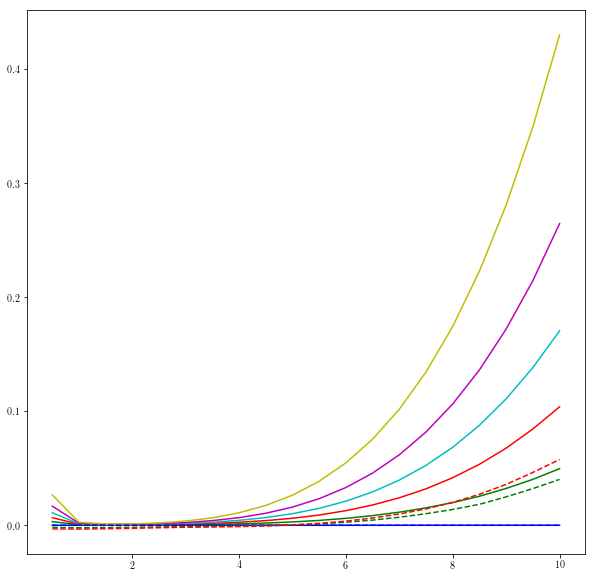

In [17]:
fig= plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for g,c in zip(np.linspace(0,0.5, 6), colors):
    bias = []
    hlr_fwhms = np.linspace(0.5, 10, 20)
    hlrs = hlr_fwhms * g_parameters1.id_params['1']['psf_fwhm']
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters1.id_params)
        id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['g1_1'])
    plt.plot(hlr_fwhms, bias, label = f"$\\varepsilon$ = {g:.2g}", color = c )


for g,c in zip(np.linspace(0,0.5, 6),colors):
    bias = []
    hlr_fwhms = np.linspace(0.5, 10, 20)
    hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
    
    #get corresponding e 
    shr = galsim.shear.Shear(g1 = g, g2 = g )
    e1, e2 = shr.e1, shr.e2 #should be the same. 
    for hlr in hlrs:
        id_params_new = deepcopy(g_parameters2.id_params)
        id_params_new['1']['e1'] = e1; id_params_new['1']['e2'] = e2; id_params_new['1']['hlr'] = hlr
        new_g_parameters = galfun.GParameters(id_params= id_params_new)
        new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
        bias.append(new_fish.biases['e1_1'])
    plt.plot(hlr_fwhms, bias, '--', color = c )
    
#plt.ylim(-.02, .02)
plt.ylabel('$b(\\varepsilon_{1}) / b(\\chi_{1})  [10^{-2}]$', size = 22)
plt.xlabel(r'\rm HLR/FWHM$_{\rm PSF}$' , size = 22 )

ax.get_yaxis().get_offset_text().set_size(20)

plt.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
plt.tick_params(axis='both', which='major', labelsize=16)

plt.legend(loc = 'best',prop={'size': 15})

## Testing new parameter for size. 

In [8]:
image_renderer = galfun.ImageRenderer(pixel_scale=.2, nx=1000,ny=1000)

In [9]:
#create nominal psf 
psf = galsim.Gaussian(fwhm = g_parameters1.id_params['1']['psf_fwhm'])
#obtain second moment trace with big image to avoid inacurracies 
psf_T = 2 * psf.calculateMomentRadius(size=(60,60))**2  # = to sigma for uncolvolved Gaussians, and exact. 


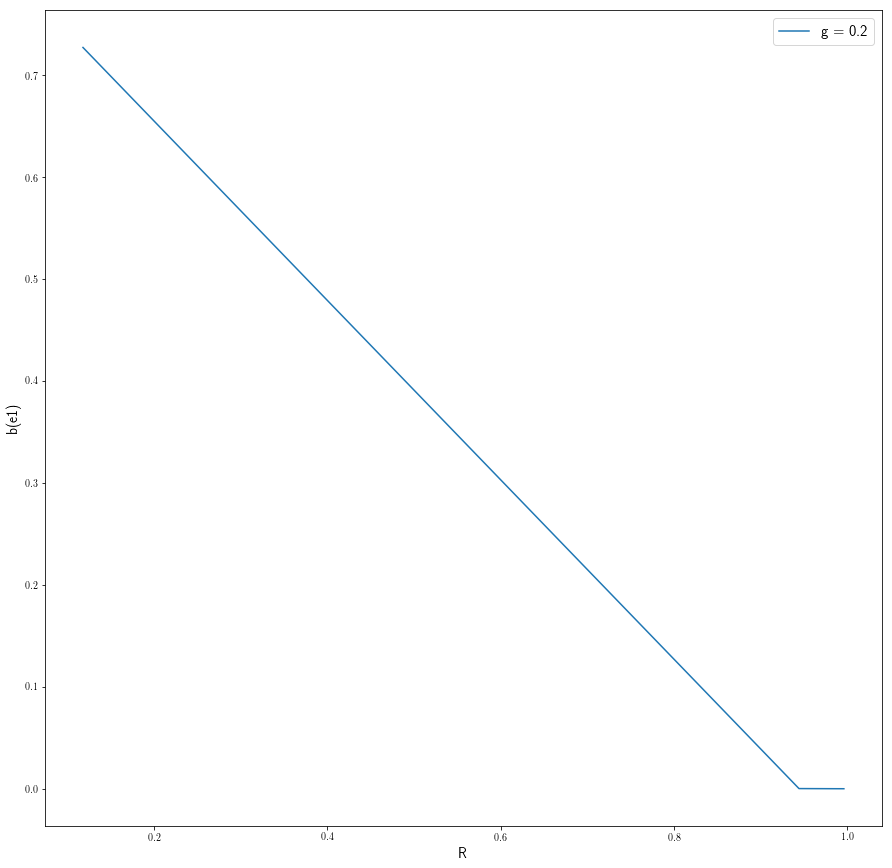

In [14]:
from copy import deepcopy
plt.figure(figsize=(15, 15))
g = .2
Rs = [] 
bias = []
hlrs = np.linspace(0.1, 5, 5 )
# hlrs = hlr_fwhms * g_parameters2.id_params['1']['psf_fwhm']
for hlr in hlrs:
    id_params_new = deepcopy(g_parameters1.id_params)
    id_params_new['1']['g1'] = g; id_params_new['1']['g2'] = g; id_params_new['1']['hlr'] = hlr
    new_g_parameters = galfun.GParameters(id_params= id_params_new)
    new_fish = fisher.Fisher(g_parameters=new_g_parameters,image_renderer=image_renderer, snr = 20)
    R = 1 - psf_T / (2 * new_fish.model.calculateMomentRadius(size = 1000, scale = .2 ,rtype= 'trace')**2 ) 
    bias.append(new_fish.biases['g1_1'])
    Rs.append(R)
plt.plot(Rs, bias, label = f"g = {g:.2g}")
plt.ylabel('b(e1)', size = 14)
plt.xlabel('R' , size = 14 )
plt.legend(loc = 'best',prop={'size': 15})

In [73]:
fish1.model.calculateMomentRadius(size = 600, scale = .2 ,rtype= 'trace')

0.93442935442023356

In [89]:
hlr = 10 
gal = galsim.Gaussian(half_light_radius=10)
final = galsim.Convolve([gal, psf])
final_T = 2 * final.calculateMomentRadius(size = 1000, scale = .2 ,rtype= 'trace')**2 
1 - psf_T / final_T

0.99877655525496434

In [241]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
g1 = 0.2
g2 = 0.2
hlr = 1.0 
psf_fwhm = .7
snr = 20. 

#project folder name where you want to write galaxy information 
project1 = 'project-tutoriaNew77' #g2 = .2 

#image parameters 
pixel_scale=.2 #arcsecs/pixel
nx = 40
ny = 40 

In [242]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 
import corner 

from matplotlib.patches import Ellipse

In [243]:
cmd = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --g1 {3} --g2 {4} --y0 1.0 --x0 1.0 \
--flux 1. --psf_flux 1. --hlr {5} --psf_fwhm {6} --snr {7}'.format(project1,model,psf_model,g1,g2,hlr,psf_fwhm,snr)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print(output)
print(cmd)

b''
python generate.py -p project-tutoriaNew77 -gal 1 --galaxy-model gaussian --psf_model psf_gaussian  --g1 0.2 --g2 0.2 --y0 1.0 --x0 1.0 --flux 1. --psf_flux 1. --hlr 1.0 --psf_fwhm 0.7 --snr 20.0


In [244]:
g_parameters = galfun.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

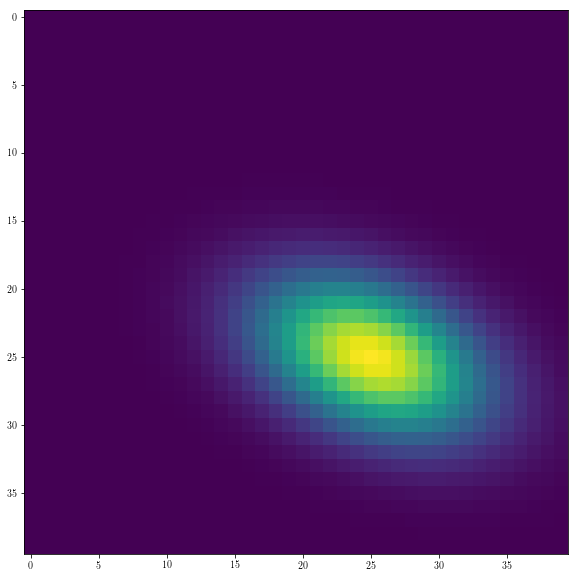

In [245]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
fig = plt.figure(figsize=(10,10))
plt.imshow(fish.image.array)
plt.show()

